# MNISTを、4点の座標情報だけで分類する

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
from time import sleep


batch_size = 10
epochs = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SpatialSoftmaxLayer(nn.Module):
    """
    C, W, H => C*2 # for each channel, get good point [x,y]
    """
    def __init__(self, n_fp, n_rows, n_cols):
        super(SpatialSoftmaxLayer, self).__init__()

        x_map = np.zeros((n_rows, n_cols))
        y_map = np.zeros((n_rows, n_cols))
        for i in range(n_rows):
            for j in range(n_cols):
                x_map[i,j] = (i - n_rows / 2) / n_rows
                y_map[i,j] = (j - n_cols / 2) / n_cols
        x_map = torch.from_numpy(np.array(x_map.reshape((-1)), np.float32)).to(device)
        y_map = torch.from_numpy(np.array(y_map.reshape((-1)), np.float32)).to(device)
        
        self.x_map = x_map
        self.y_map = y_map
        
    def forward(self, x): # after relu
        x = x.view(x.shape[0], x.shape[1], x.shape[2]*x.shape[3]) # batch, C, W*H
        x = F.softmax(x, 2) # batch, C, W*H
        fp_x = torch.matmul(x, self.x_map) # batch, C
        fp_y = torch.matmul(x, self.y_map) # batch, C
        x = torch.cat((fp_x, fp_y), 1)
        return x # batch, C*2

class SpatialSoftmaxNet(nn.Module):
    def __init__(self):
        h = 16
        super(SpatialSoftmaxNet, self).__init__()
        self.conv1 = nn.Conv2d(1, h, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(h, 4, kernel_size=3, padding=1)
        self.spatial_softmax = SpatialSoftmaxLayer(4, 28, 28)
        self.bn1 = nn.BatchNorm2d(h)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4*2, 4*2)
        self.fc2 = nn.Linear(4*2, 10)

        init.xavier_normal_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        init.xavier_normal_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        init.normal_(self.fc1.weight, 0, 0.01)
        init.constant_(self.fc1.bias, 1)
        init.normal_(self.fc2.weight, 0, 0.01)
        init.constant_(self.fc2.bias, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), 2) # => 28x28x64
        x = F.relu(self.bn2(self.conv2(x)), 2) # => 28x28x64
        
        # ----------------------------------------------------------------
        # spatial_softmax
        # ----------------------------------------------------------------
        x = self.spatial_softmax(x) # => 64*2
        
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    
    # for visualization
    def forward_conv(self, x):
        x = F.relu(self.bn1(self.conv1(x)), 2)
        x = F.relu(self.bn2(self.conv2(x)), 2)
        
        return x
    
    # for visualization
    def forward_spatial_softmax(self, x):
        x = F.relu(self.bn1(self.conv1(x)), 2)
        x = F.relu(self.bn2(self.conv2(x)), 2)
        x = self.spatial_softmax(x)
        
        return x

    
def train(model, device, train_data_loader, optimizer):
    model.train()
    
    sleep(0.5)
    with tqdm(train_data_loader) as _tqdm:
        for data, target in _tqdm:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            _tqdm.set_postfix(OrderedDict(loss=loss.item()))

def test(model, device, test_data_loader):
    model.eval()
    loss = 0
    acc = 0
    
    sleep(0.5)
    with torch.no_grad():
        with tqdm(test_data_loader) as _tqdm:
            for data, target in _tqdm:
                data, target = data.to(device), target.to(device)
                output = model(data)
                temp_loss = F.nll_loss(output, target, reduction='sum').item()
                loss += temp_loss
                pred = output.max(1, keepdim=True)[1]
                temp_acc = pred.eq(target.view_as(pred)).sum().item()
                acc += temp_acc
                _tqdm.set_postfix(OrderedDict(loss=temp_loss/len(data), acc=temp_acc/len(data)))
    
    loss /= len(test_data_loader.dataset)
    acc /= len(test_data_loader.dataset)
    # return loss, acc

In [2]:
train_data_loader = DataLoader(
    datasets.MNIST('./mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True)

test_data_loader = DataLoader(
    datasets.MNIST('./mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True)

model = SpatialSoftmaxNet().to(device)
optimizer = optim.Adam(model.parameters()) # SGD is very very bad.

In [3]:
for epoch in range(1, epochs + 1):
    train(model, device, train_data_loader, optimizer)
    test(model, device, test_data_loader)

100%|██████████| 1000/1000 [00:07<00:00, 134.73it/s, loss=1, acc=0.7]   


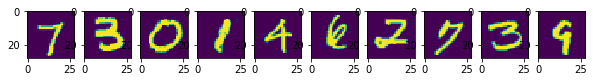

[7 3 0 1 4 6 2 7 3 9]
[7 3 0 1 4 2 3 7 3 4]


In [4]:
for images, labels in test_data_loader:
    plt.figure(figsize=(10,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    break

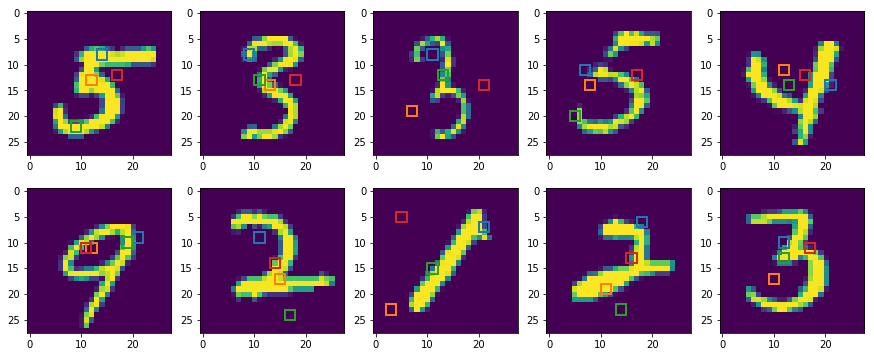

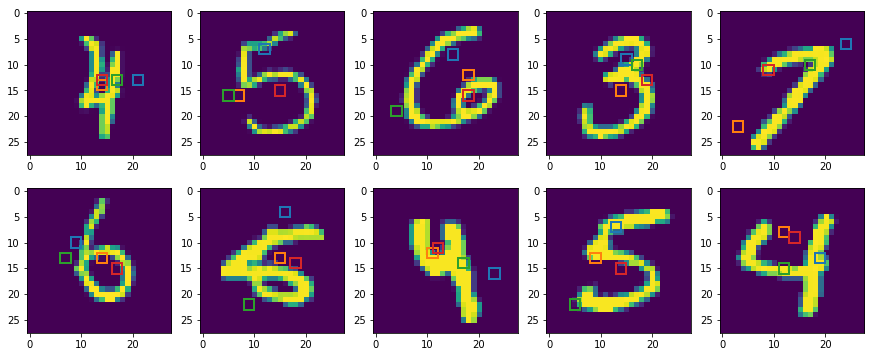

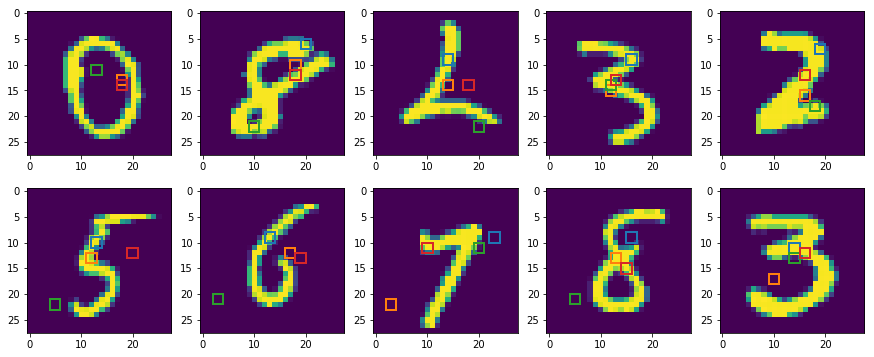

In [5]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (images, labels) in enumerate(test_data_loader):
    
    fp = model.forward_spatial_softmax(images.to(device)).detach().numpy().reshape((batch_size, 2, 4)).transpose(0,2,1)
    fp = np.array(fp*28 + 14, np.int)
    
    plt.figure(figsize=(15,6))
    for j, image in enumerate(images):
        plt.subplot(2, 5,j+1)
        ax = plt.gca()
        plt.imshow(image.reshape(28,28))
        for p, c in zip(fp[j], color):
            ax.add_patch(plt.Rectangle((p[0]-1,p[1]-1), 2, 2, color=c, linewidth=2, fill=False))
    plt.show()
    if i>=2:
        break

feature map 0


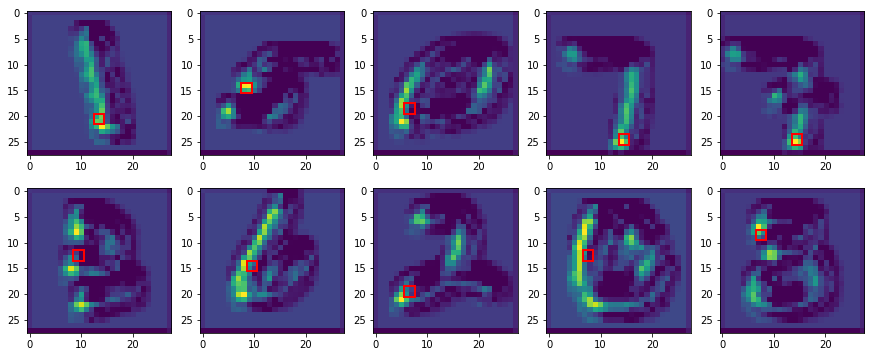

feature map 1


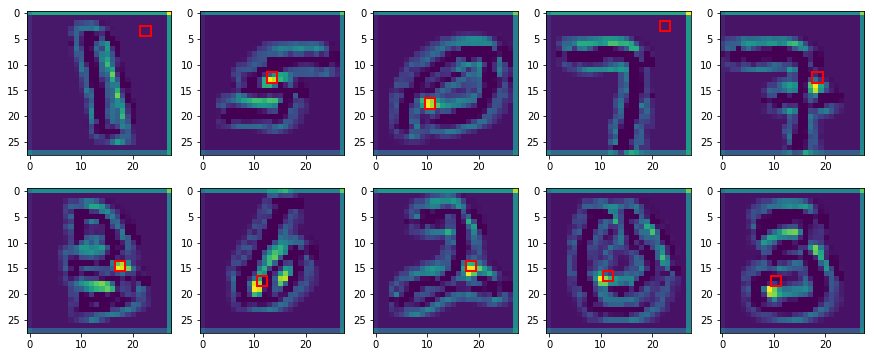

feature map 2


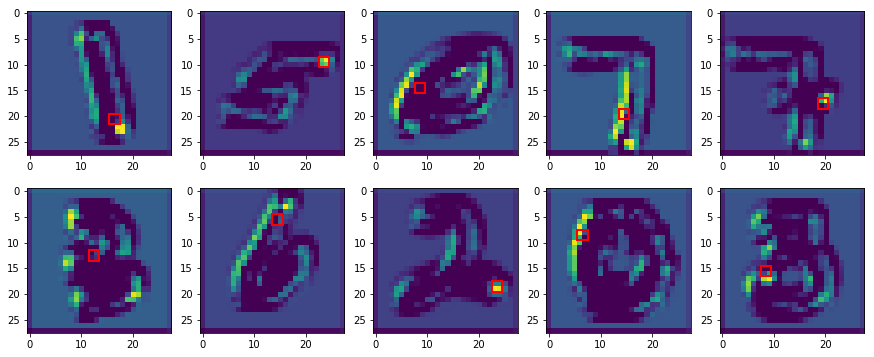

feature map 3


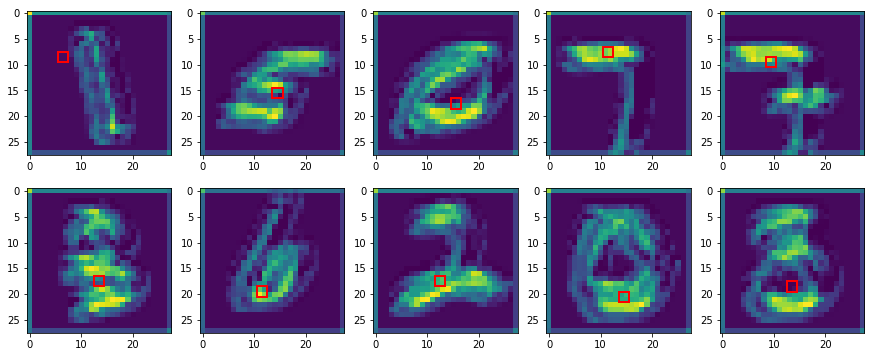

In [6]:
for i, (images, labels) in enumerate(test_data_loader):
    
    fp = model.forward_spatial_softmax(images.to(device)).detach().numpy().reshape((batch_size, 2, 4)).transpose(0,2,1)
    fp = np.array(fp*28 + 14, np.int)    
   
    images = model.forward_conv(images).detach().numpy()
    
    for k in range(4):
        print("feature map", k)
        plt.figure(figsize=(15,6))
        for j, image in enumerate(images):
            plt.subplot(2, 5,j+1)
            ax = plt.gca()
            plt.imshow(image.reshape(4, 28,28)[k])
            p = fp[j][k]
            ax.add_patch(plt.Rectangle((p[1]-0.5,p[0]-0.5), 2, 2, color="r", linewidth=2, fill=False))
        plt.show()
    break